_Lambda School Data Science — Model Validation_ 

# Begin the modeling process

Objectives
- Train/Validate/Test split
- Cross-Validation
- Begin with baselines

## Get the Bank Marketing dataset

You have several ways you can get the dataset:

#### Kaggle
- Download from the [Kaggle competition page](https://www.kaggle.com/c/ds2-model-validation/data)
- Use the Kaggle API

#### GitHub
- Clone the [repo](https://github.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/tree/master/module-1-begin-modeling-process/bank-marketing)
- Download from the repo:

#### Kaggle Configuration

In [5]:
path_to_config = "../kaggle.json"
kaggle_config = json.loads(open(path_to_config).read())
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

#### Imports

In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json
import warnings
import kaggle

In [42]:
kaggle.api.competition_download_files("ds2-model-validation", "data/bank-marketing", quiet=False)

  0%|          | 0.00/424k [00:00<?, ?B/s]

100%|██████████| 424k/424k [00:00<00:00, 504kB/s]


  0%|          | 0.00/241k [00:00<?, ?B/s]

100%|██████████| 241k/241k [00:00<00:00, 596kB/s]


  0%|          | 0.00/142k [00:00<?, ?B/s]

100%|██████████| 142k/142k [00:00<00:00, 496kB/s]


  0%|          | 0.00/101k [00:00<?, ?B/s]

100%|██████████| 101k/101k [00:00<00:00, 485kB/s]

#### Extract Kaggle Competition Data

In [54]:
!ls -lsh data/bank-marketing

total 916K
104K -rw-r--r-- 1 root root 101K Mar  4 17:30 sample_submission.csv
144K -rw-r--r-- 1 root root 142K Mar  4 17:30 test_features.csv.zip
424K -rw-r--r-- 1 root root 424K Mar  4 17:30 train_features.csv.zip
244K -rw-r--r-- 1 root root 242K Mar  4 17:30 train_labels.csv


In [63]:
!for zipfile in $(pwd)/data/bank-marketing/*.csv.zip; do unzip $zipfile -d $(pwd)/data/bank-marketing/; done

Archive:  /Users/work/.work/src/projects/lambdaschool/unit-2/DS-Unit-2-Sprint-4-Model-Validation/module-1-begin-modeling-process/data/bank-marketing/test_features.csv.zip
  inflating: /Users/work/.work/src/projects/lambdaschool/unit-2/DS-Unit-2-Sprint-4-Model-Validation/module-1-begin-modeling-process/data/bank-marketing/test_features.csv  
Archive:  /Users/work/.work/src/projects/lambdaschool/unit-2/DS-Unit-2-Sprint-4-Model-Validation/module-1-begin-modeling-process/data/bank-marketing/train_features.csv.zip
  inflating: /Users/work/.work/src/projects/lambdaschool/unit-2/DS-Unit-2-Sprint-4-Model-Validation/module-1-begin-modeling-process/data/bank-marketing/train_features.csv  


In [66]:
!ls -lsh data/bank-marketing

total 5.8M
104K -rw-r--r-- 1 root root 101K Mar  4 17:30 sample_submission.csv
1.3M ---------- 1 root root 1.3M Mar  4 14:02 test_features.csv
144K -rw-r--r-- 1 root root 142K Mar  4 17:30 test_features.csv.zip
3.7M ---------- 1 root root 3.7M Mar  4 14:02 train_features.csv
424K -rw-r--r-- 1 root root 424K Mar  4 17:30 train_features.csv.zip
244K -rw-r--r-- 1 root root 242K Mar  4 17:30 train_labels.csv


In [71]:
!head data/bank-marketing/train_*.csv

head: cannot open 'data/bank-marketing/train_features.csv' for reading: Permission denied
==> data/bank-marketing/train_labels.csv <==
id,y
20591,0
18343,0
32826,0
29780,0
40736,0
10874,0
31365,0
35401,0
48167,0


In [72]:
!chmod +r data/bank-marketing/*.csv

#### Load Data

In [379]:
base = 'data/bank-marketing'

train_features = pd.read_csv(base+'/train_features.csv')
train_labels = pd.read_csv(base+'/train_labels.csv')
test_features = pd.read_csv(base+'/test_features.csv')
sample_submission = pd.read_csv(base+'/sample_submission.csv')

train_features.shape, train_labels.shape, test_features.shape, sample_submission.shape

((30891, 20), (30891, 2), (10297, 20), (10297, 2))

In [380]:
y_train = train_labels['y']
X_train = train_features.drop(columns='id')
X_test  = test_features.drop(columns='id')

## Train/Validation/Test split

How can we get from a two-way split, to a three-way split?

We can use the [**`sklearn.model_selection.train_test_split`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split the training data into training and validation data.

In [381]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((23168, 19), (7723, 19), (23168,), (7723,))

Fit on the training set.

Predict and score with the validation set.

## Majority class baseline

Determine the majority class:

0    0.890769
1    0.109231
Name: y, dtype: float64

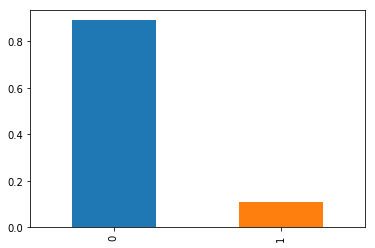

In [124]:
y_train.value_counts(normalize=True).plot.bar()
y_train.value_counts(normalize=True)

#### [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Baseline accuracy by guessing the majority class for every prediction:

Guess the majority class for every prediction:

In [145]:
y_pred = np.zeros(y_val.size)
accuracy_score(y_val, y_pred)

0.88225138121546964

In [146]:
y_pred = np.ones(y_val.size)
accuracy_score(y_val, y_pred)

0.11774861878453038

#### [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

Baseline "ROC AUC" score by guessing the majority class for every prediction:

In [148]:
y_pred = np.zeros(y_val.size)
roc_auc_score(y_val, y_pred)

0.5

In [149]:
y_pred = np.ones(y_val.size)
roc_auc_score(y_val, y_pred)

0.5

## Fast first models

### Ignore rows/columns with nulls

This dataset doesn't have any nulls:

In [143]:
X_train.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

### Ignore nonnumeric features

Here are the numeric features:

In [156]:
X_train.describe(include=np.number)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,13032.000000,13032.000000,13032.000000,13032.000000,13032.000000,13032.000000,13032.000000,13032.000000,13032.000000
mean,39.912753,2.540285,961.435390,0.175568,0.071662,93.572016,-40.529995,3.609746,5166.782190
std,10.338006,2.690560,189.455309,0.497426,1.572646,0.578880,4.620847,1.736808,72.107269
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,37.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Here are the nonnumeric features:

In [157]:
X_train.describe(exclude=np.number)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,mon,nonexistent
freq,3266,7878,3825,10304,6738,10749,8301,4377,2698,11212


Just select the nonnumeric features:

In [158]:
X_train_numeric = X_train.select_dtypes(np.number)
X_val_numeric = X_val.select_dtypes(np.number)

In [163]:
X_train_numeric.shape, y_train.shape

((13032, 9), (13032,))

In [164]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_numeric, y_train)

y_pred = model.predict(X_val_numeric)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC:", roc_auc_score(y_val, y_pred))

Accuracy: 0.897790055249
ROC: 0.575107943029


### With Scaler

In [183]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_val_scaled = scaler.transform(X_val_numeric)

In [184]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC:", roc_auc_score(y_val, y_pred))

Accuracy: 0.897790055249
ROC: 0.57418454381


### Same, as a pipeline

In [185]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('regressor', LogisticRegression(solver='lbfgs', max_iter=1000))
])

pipeline.fit(X_train_scaled, y_train)

y_pred = pipeline.predict(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC:", roc_auc_score(y_val, y_pred))

Accuracy: 0.897790055249
ROC: 0.57418454381


### Encode "low cardinality" categoricals

One-hot encode the "low cardinality" categoricals

In [186]:
X_train.select_dtypes(exclude=np.number).nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

Install the Category Encoder library

If you're running on Google Colab:

```
!pip install category_encoders
```

If you're running locally with Anaconda:

```
!conda install -c conda-forge category_encoders
```

In [189]:
import category_encoders as ce

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
roc_auc_score(y_val, y_pred)

0.59250452313259239

#### Assignment

In [8]:
sample_submission = pd.read_csv(base+'/sample_submission.csv')

sample_submission.sample(5)

,id,y
7798,19977,0.5
7994,49829,0.5
3557,21027,0.5
1259,26557,0.5
4102,22440,0.5


#### Load Data

In [243]:
base = 'data/bank-marketing'

train_features = pd.read_csv(base+'/train_features.csv')
train_labels = pd.read_csv(base+'/train_labels.csv')
test_features = pd.read_csv(base+'/test_features.csv')

train_features.shape, train_labels.shape, test_features.shape

((30891, 20), (30891, 2), (10297, 20))

In [98]:
X = train_features
y = train_labels.y

#### Split Data

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Visualize Data

In [100]:
X_train.head()

,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
8977,36258,44,admin.,married,university.degree,unknown,yes,no,telephone,jun,thu,2,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1
13934,44642,48,blue-collar,married,professional.course,no,yes,no,telephone,may,thu,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
27642,13006,55,services,divorced,high.school,no,yes,no,cellular,jul,fri,3,999,0,nonexistent,-1.7,94.215,-40.3,0.896,4991.6
21105,13120,54,retired,married,basic.4y,no,no,yes,cellular,oct,thu,2,999,0,nonexistent,-3.4,92.431,-26.9,0.722,5017.5
14500,36076,40,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,fri,3,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0


#### Baseline Model

In [101]:
classifier = DummyClassifier().fit(X_train, y_train)

array([ 0.88812155,  0.11187845])

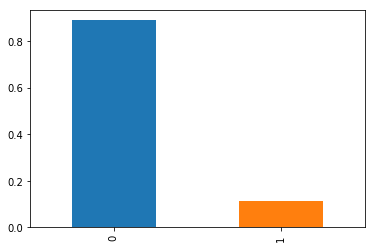

In [102]:
pd.Series(classifier.class_prior_).plot.bar()
classifier.class_prior_

In [103]:
y_pred = classifier.predict(X_train)

In [104]:
pd.Series(y_pred).value_counts()

0    20553
1     2615
dtype: int64

In [105]:
pd.Series(y_train).value_counts()

0    20576
1     2592
Name: y, dtype: int64

In [106]:
print("Accuracy:", accuracy_score(y_train, y_pred))
print("ROC:", roc_auc_score(y_train, y_pred)) # Slightly worse than randomly guessing

Accuracy: 0.799853245856
ROC: 0.498357489488


#### Cleaning

In [107]:
train_features['loan'] = train_features.loan.replace({'yes': True, 'no': False, 'unknown': False})
train_features['housing'] = train_features.housing.replace({'yes': True, 'no': False, 'unknown': False})

#### Feature Engineering

In [108]:
train_features.head()

,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,20591,29,services,single,high.school,no,True,True,cellular,may,thu,10,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1
1,18343,54,management,married,university.degree,no,False,False,cellular,nov,tue,1,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8
2,32826,55,self-employed,married,unknown,unknown,False,False,cellular,jul,mon,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
3,29780,43,blue-collar,married,unknown,unknown,False,False,cellular,may,mon,6,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1
4,40736,54,blue-collar,married,basic.4y,no,True,False,telephone,may,wed,5,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0


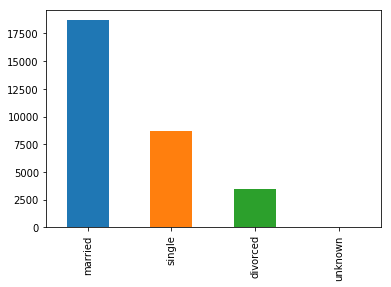

In [109]:
train_features.marital.value_counts().plot.bar()

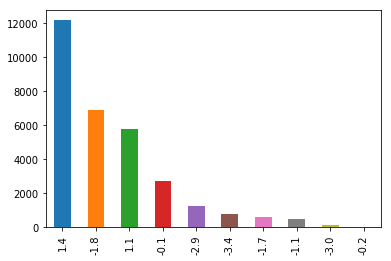

In [110]:
train_features['emp.var.rate'].value_counts().plot.bar()

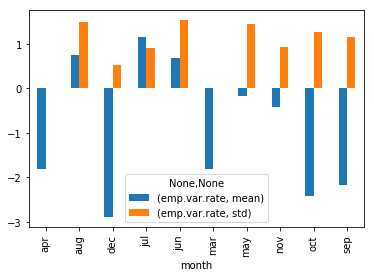

In [111]:
train_features[['emp.var.rate', 'month']].groupby('month').agg(['mean', 'std']).plot.bar()

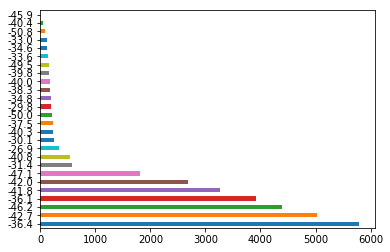

In [112]:
train_features['cons.conf.idx'].value_counts().plot.barh()

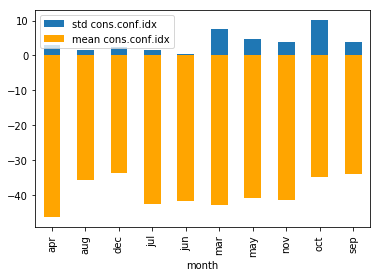

In [113]:
ax = train_features[['cons.conf.idx', 'month']].groupby('month').std().rename(columns={'cons.conf.idx': 'std cons.conf.idx'}).plot.bar()
train_features[['cons.conf.idx', 'month']].groupby('month').mean().rename(columns={'cons.conf.idx': 'mean cons.conf.idx'}).plot.bar(ax=ax, color='orange')

In [114]:
train_features['cons.conf.idx'].describe()

count    30891.000000
mean       -40.505872
std          4.629710
min        -50.800000
25%        -42.700000
50%        -41.800000
75%        -36.400000
max        -26.900000
Name: cons.conf.idx, dtype: float64

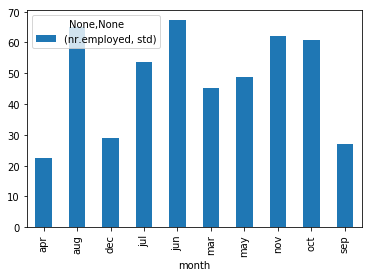

In [115]:
train_features[['nr.employed', 'month']].groupby('month').agg(['std']).plot.bar()

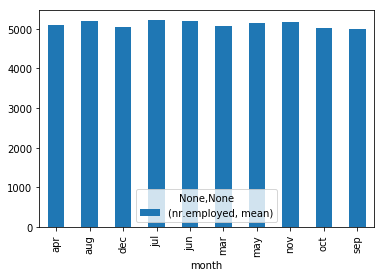

In [116]:
train_features[['nr.employed', 'month']].groupby('month').agg(['mean']).plot.bar()

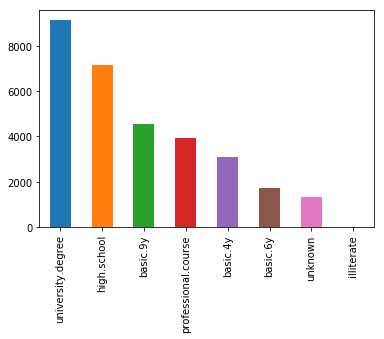

In [117]:
train_features.education.value_counts().plot.bar()

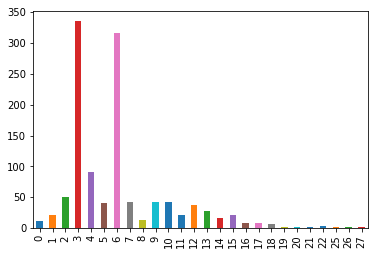

In [118]:
train_features.pdays[train_features.pdays != 999].value_counts().sort_index().plot.bar()

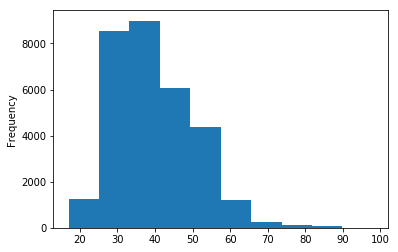

In [119]:
train_features.age.plot.hist()

In [120]:
# You know this, I know this, but magic numbers are bad
average_sample_year = (2008 + 2009 + 2010)/3

Text(0.5,1,'Births Per Year')

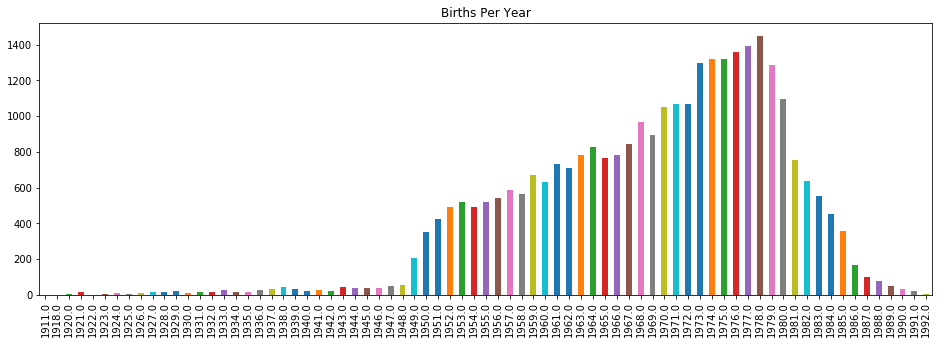

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(16,5))
(average_sample_year - train_features.age).value_counts().sort_index().plot.bar(ax=ax)

plt.title("Births Per Year")

Text(0.5,1,'Frequency Of Ages Among Holders Of Personal Loans')

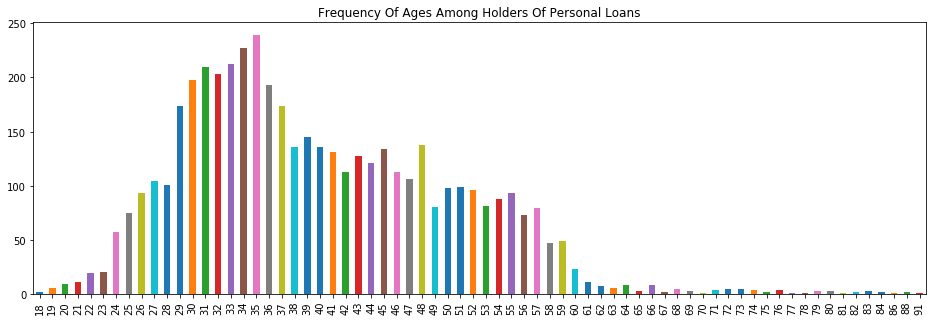

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(16,5))
train_features.age[train_features.loan == True].value_counts().sort_index().plot.bar(ax=ax)

plt.title("Frequency Of Ages Among Holders Of Personal Loans")

Text(0.5,1,'Frequency Of Ages Among Holders Of Housing Loans')

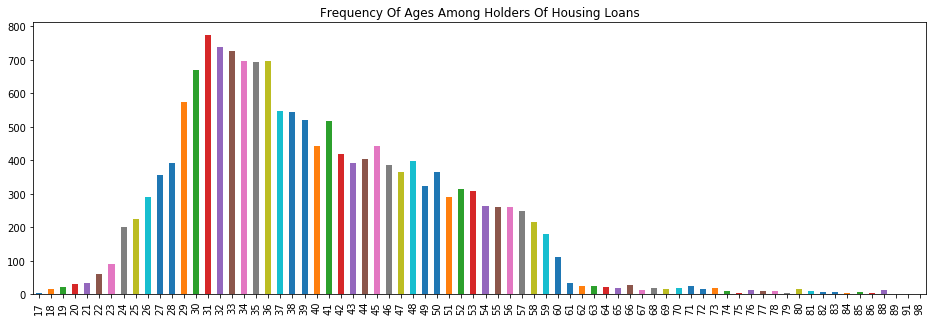

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(16,5))
train_features.age[train_features.housing == True].value_counts().sort_index().plot.bar(ax=ax)

plt.title("Frequency Of Ages Among Holders Of Housing Loans")

Text(0.5,1,'Frequency Of Ages')

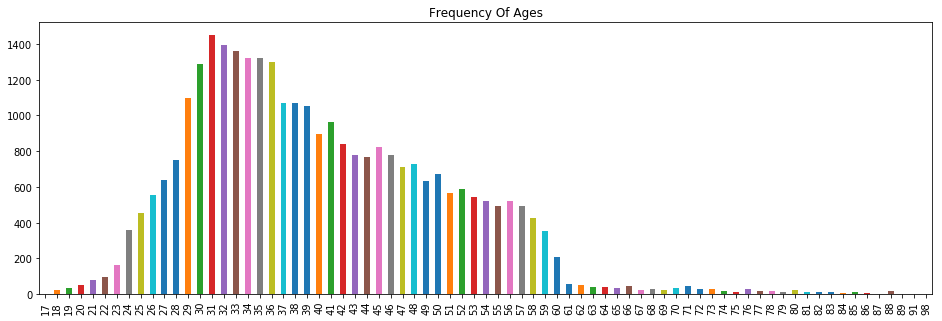

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(16,5))
train_features.age.value_counts().sort_index().plot.bar(ax=ax)

plt.title("Frequency Of Ages")

In [308]:
train_features['ambitious'] = (train_features.age < 30) & ((train_features.job == 'self-employed') | (train_features.job == 'entrepreneur'))
train_features['hard_working'] = (train_features.education != 'university.degree') & (train_features.job == 'self-employed')
train_features['under_thirty_loan'] = (train_features.age < 30) & (train_features.loan == True)
train_features['romantic'] = (train_features.age < 30) & (train_features.marital == 'married')
train_features['boost_strapping'] = (train_features.loan  == True) & (train_features.job == 'entrepreneur')
train_features['wise_and_experienced'] = (train_features.job != 'retired') & (train_features.age > 55)
train_features['first_contact'] = train_features['pdays'] == 999
train_features['fully_loaded'] = (train_features.housing == True) & (train_features.loan == True)
train_features['in_dire_straits'] = train_features.fully_loaded & (train_features['default'] == True)
train_features['approx_birth'] = average_sample_year - train_features.age 
train_features['precocious'] = (train_features.age < 22) & (train_features.education == 'university.degree')
train_features['really_quite_old'] = (train_features.approx_birth <= 1942)
train_features['baby_boomer'] = (1942 < train_features.approx_birth) & (train_features.approx_birth <= 1964)
train_features['generation_x'] = (1964 < train_features.approx_birth) & (train_features.approx_birth <= 1982)
train_features['millenial'] = (1982 < train_features.approx_birth) & (train_features.approx_birth <= 1997)

# these are in terrible taste, forgive my sins
train_features['lying_or_lucky'] = (train_features.age < 30) & (train_features.job == 'retired')
train_features['moving_fast_and_breaking_things'] = (train_features.job == 'entrepreneur') & (train_features.marital == 'divorced')
train_features['overqualified_at_life'] = (train_features.education == 'university.degree') & (train_features.job == 'housemaid')
# shout out to philosophy majors, because that's actaully a great major
train_features['philosophy_major'] = (train_features.education == 'university.degree') & (train_features.job == 'unemployed')

In [309]:
train_features['day_of_week'] = train_features.day_of_week.replace({
    'mon': 'monday',
    'tue': 'tuesday',
    'wed': 'wednesday',
    'thu': 'thursday',
    'fri': 'friday'
}).str.capitalize()

In [310]:
train_features['month'] = train_features.month.replace({
    'mar': 'march',
    'apr': 'april',
    'may': 'may',
    'jun': 'june',
    'jul': 'july',
    'aug': 'august',
    'sep': 'september',
    'oct': 'october',
    'nov': 'november',
    'dec': 'december'
}).str.capitalize()

In [311]:
train_features.columns.values

array(['id', 'age', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'ambitious',
       'hard_working', 'under_thirty_loan', 'romantic', 'boost_strapping',
       'wise_and_experienced', 'first_contact', 'fully_loaded',
       'in_dire_straits', 'approx_birth', 'precocious', 'really_quite_old',
       'baby_boomer', 'generation_x', 'millenial', 'lying_or_lucky',
       'moving_fast_and_breaking_things', 'overqualified_at_life',
       'philosophy_major'], dtype=object)

In [312]:
train_features.dtypes

id                                   int64
age                                  int64
job                                 object
marital                             object
education                           object
default                             object
housing                             object
loan                                object
contact                             object
month                               object
day_of_week                         object
campaign                             int64
pdays                                int64
previous                             int64
poutcome                            object
emp.var.rate                       float64
cons.price.idx                     float64
cons.conf.idx                      float64
euribor3m                          float64
nr.employed                        float64
ambitious                             bool
hard_working                          bool
under_thirty_loan                     bool
romantic   

In [313]:
features = train_features\
    .assign(**pd.concat([pd.get_dummies(train_features[column]) for column in train_features.select_dtypes(exclude=[np.number, np.bool])], sort=False, axis=1).to_dict(orient='series'))\
    .assign(**pd.DataFrame(StandardScaler().fit_transform(train_features.drop(columns=['id', 'age', 'campaign']).select_dtypes(include=np.number)), columns=train_features.drop(columns=['id', 'age', 'campaign']).select_dtypes(include=np.number).columns, index=train_features.index).to_dict(orient='series'))\
    .assign(**train_features.select_dtypes(exclude=[np.number, np.bool]).apply(LabelEncoder().fit_transform).to_dict(orient='series'))\
    .assign(**train_features.select_dtypes(include=np.bool).astype(np.number).to_dict(orient='series'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [314]:
features.dtypes.value_counts()

uint8      44
float64    26
int64      13
dtype: int64

In [315]:
features.isna().sum().sum()

0

#### Split Out Features

In [318]:
X = features
y = train_labels.y

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [320]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23168, 83), (7723, 83), (23168,), (7723,))

#### Logistic Regression

In [321]:
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [322]:
y_pred = model.predict(X_test)

In [323]:
pd.Series(y_pred).value_counts()

0    7477
1     246
dtype: int64

In [324]:
pd.Series(y_train).value_counts()

0    20539
1     2629
Name: y, dtype: int64

In [325]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.901204195261
ROC: 0.592371896242


#### Prune Ineffective Features

In [326]:
coefficients = pd.Series(model.coef_[0], index=X_train.columns.values)
coefficient_magnitudes = np.abs(coefficients)

In [327]:
model.coef_.shape, X_train.columns.values.shape

((1, 83), (83,))

Text(0.5,1,'The Magnitude Of Feature Importance')

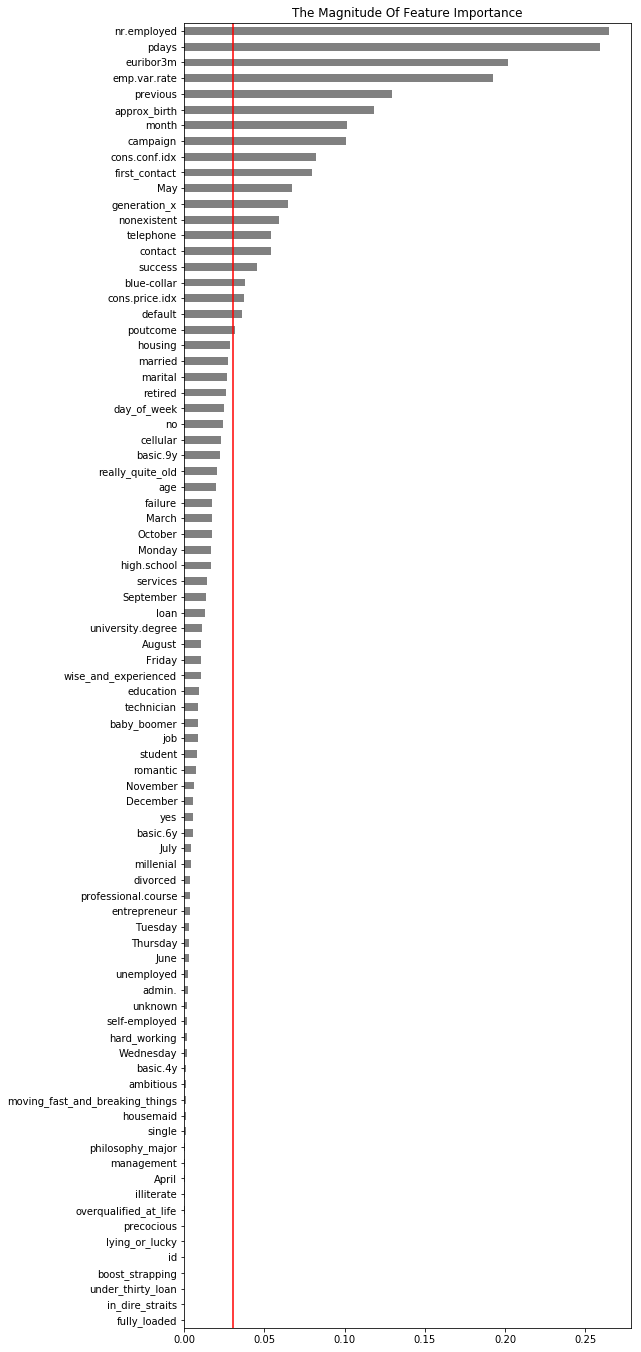

In [329]:
fig, ax = plt.subplots(1, 1, figsize=(8,24))
coefficient_magnitudes.sort_values().plot.barh(color='gray', ax=ax)

plt.axvline(coefficient_magnitudes.mean(), color='red')

plt.title("The Magnitude Of Feature Importance")

In [330]:
refined_coefficients = coefficients[coefficient_magnitudes.mean() < coefficient_magnitudes]

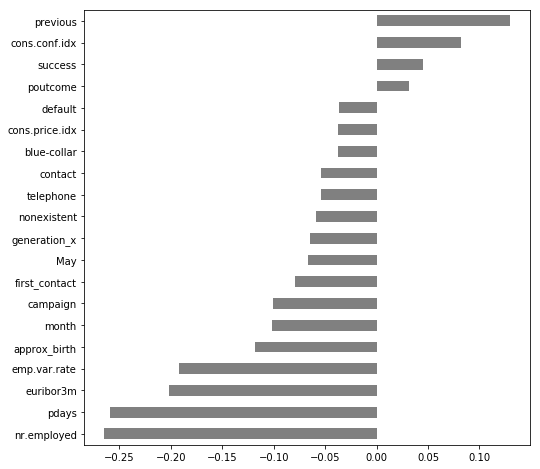

In [331]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
refined_coefficients.sort_values().plot.barh(color='gray', ax=ax)

#### Refined Logistic Regression

In [332]:
refined = features[refined_coefficients.index.values]

In [333]:
X = refined
y = train_labels.y

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [335]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23168, 20), (7723, 20), (23168,), (7723,))

In [336]:
model = LogisticRegression(solver='saga')
model.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [337]:
y_pred = model.predict(X_test)

In [338]:
pd.Series(y_pred).value_counts()

0    7418
1     305
dtype: int64

In [339]:
pd.Series(y_train).value_counts()

0    20530
1     2638
Name: y, dtype: int64

In [340]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.905865596271
ROC: 0.617800021471


Text(0.5,1,'The Magnitude Of Feature Importance')

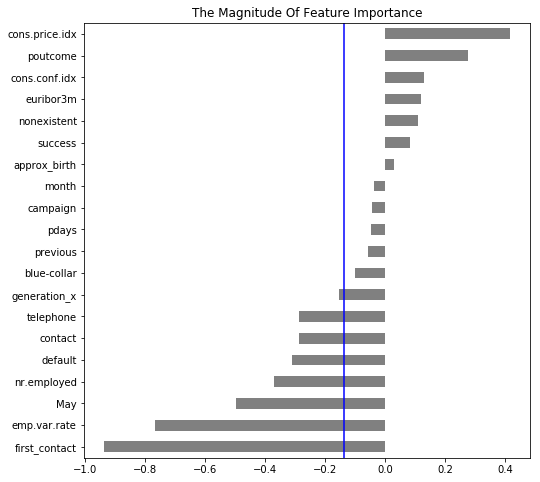

In [341]:
coefficients = pd.Series(model.coef_[0], index=X_train.columns.values)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
coefficients.sort_values().plot.barh(color='gray', ax=ax)

plt.axvline(coefficients.mean(), color='blue')

plt.title("The Magnitude Of Feature Importance")

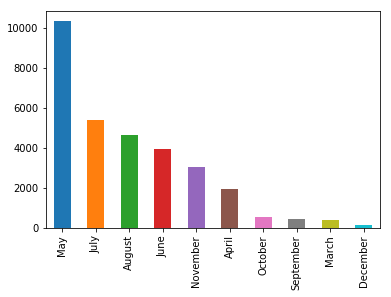

In [235]:
train_features.month.value_counts().plot.bar()

#### Whole Dataset

In [353]:
X_test = test_features = pd.read_csv(base+'/test_features.csv')

In [354]:
X_test['loan'] = X_test.loan.replace({'yes': True, 'no': False, 'unknown': False})
X_test['housing'] = X_test.housing.replace({'yes': True, 'no': False, 'unknown': False})

In [355]:
X_test['ambitious'] = (X_test.age < 30) & ((X_test.job == 'self-employed') | (X_test.job == 'entrepreneur'))
X_test['hard_working'] = (X_test.education != 'university.degree') & (X_test.job == 'self-employed')
X_test['under_thirty_loan'] = (X_test.age < 30) & (X_test.loan == True)
X_test['romantic'] = (X_test.age < 30) & (X_test.marital == 'married')
X_test['boost_strapping'] = (X_test.loan  == True) & (X_test.job == 'entrepreneur')
X_test['wise_and_experienced'] = (X_test.job != 'retired') & (X_test.age > 55)
X_test['first_contact'] = X_test['pdays'] == 999
X_test['fully_loaded'] = (X_test.housing == True) & (X_test.loan == True)
X_test['in_dire_straits'] = X_test.fully_loaded & (X_test['default'] == True)
X_test['approx_birth'] = average_sample_year - X_test.age 
X_test['precocious'] = (X_test.age < 22) & (X_test.education == 'university.degree')
X_test['really_quite_old'] = (X_test.approx_birth <= 1942)
X_test['baby_boomer'] = (1942 < X_test.approx_birth) & (X_test.approx_birth <= 1964)
X_test['generation_x'] = (1964 < X_test.approx_birth) & (X_test.approx_birth <= 1982)
X_test['millenial'] = (1982 < X_test.approx_birth) & (X_test.approx_birth <= 1997)

# these are in terrible taste, forgive my sins
X_test['lying_or_lucky'] = (X_test.age < 30) & (X_test.job == 'retired')
X_test['moving_fast_and_breaking_things'] = (X_test.job == 'entrepreneur') & (X_test.marital == 'divorced')
X_test['overqualified_at_life'] = (X_test.education == 'university.degree') & (X_test.job == 'housemaid')
# shout out to philosophy majors, because that's actaully a great major
X_test['philosophy_major'] = (X_test.education == 'university.degree') & (X_test.job == 'unemployed')

In [356]:
X_test['day_of_week'] = X_test.day_of_week.replace({
    'mon': 'monday',
    'tue': 'tuesday',
    'wed': 'wednesday',
    'thu': 'thursday',
    'fri': 'friday'
}).str.capitalize()

In [357]:
X_test['month'] = X_test.month.replace({
    'mar': 'march',
    'apr': 'april',
    'may': 'may',
    'jun': 'june',
    'jul': 'july',
    'aug': 'august',
    'sep': 'september',
    'oct': 'october',
    'nov': 'november',
    'dec': 'december'
}).str.capitalize()

In [358]:
features_test = X_test\
    .assign(**pd.concat([pd.get_dummies(X_test[column]) for column in X_test.select_dtypes(exclude=[np.number, np.bool])], sort=False, axis=1).to_dict(orient='series'))\
    .assign(**pd.DataFrame(StandardScaler().fit_transform(X_test.drop(columns=['id', 'age', 'campaign']).select_dtypes(include=np.number)), columns=X_test.drop(columns=['id', 'age', 'campaign']).select_dtypes(include=np.number).columns, index=X_test.index).to_dict(orient='series'))\
    .assign(**X_test.select_dtypes(exclude=[np.number, np.bool]).apply(LabelEncoder().fit_transform).to_dict(orient='series'))\
    .assign(**X_test.select_dtypes(include=np.bool).astype(np.number).to_dict(orient='series'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [373]:
model = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=5000)
model.fit(features.drop(columns='yes'), train_labels.y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [374]:
y_pred = model.predict(features.drop(columns='yes'))

In [375]:
pd.Series(y_pred).value_counts()

0    29836
1     1055
dtype: int64

In [376]:
pd.Series(train_labels.y).value_counts()

0    27411
1     3480
Name: y, dtype: int64

In [377]:
print("Accuracy:", accuracy_score(train_labels.y, y_pred))
print("ROC:", roc_auc_score(train_labels.y, y_pred))

Accuracy: 0.899550030753
ROC: 0.596689914318


In [378]:
refined_test = features_test#[refined_coefficients.index.values]

In [379]:
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

#### Submit To Kaggle

In [382]:
submission = sample_submission.copy()
submission['y'] = model.predict_proba(refined_test)[:, 1:]
submission.shape

(10297, 2)

In [383]:
submission.to_csv('colejhudson-test-submission-004.csv', index=False)

In [384]:
kaggle.api.competition_submit('colejhudson-test-submission-004.csv', 'AGI-v3', 'ds2-model-validation')

100%|██████████| 261k/261k [00:04<00:00, 57.5kB/s] 


Successfully submitted to DS2 Model Validation